# KiDs Catalogs

Notebook to explore the data available in the KiDs catalog.

In [35]:
import h5py as h
import numpy as np
from astropy.io import fits
import pandas
import matplotlib.pyplot as plt

## Load Catalogs

In [2]:
dirname = '/global/cscratch1/sd/elp25/txpipe-reanalysis/data/kids/'
#Load the files 

s = h.File(dirname+'shear_catalog_kids450_nonmetacal.h5', 'r')
p = h.File(dirname+'photometry_catalog_kids450_nonmetacal.h5', 'r')

Check the size of the catalogs.

In [4]:
print(len(s['/shear/flags'][()]))
print(len(p['/photometry/ra'][()]))

14650348
14650348


In [7]:
shear_data = pd.DataFrame({})
for member in s['/shear']:
    shear_data[member] = s['/shear/'+member][()]

In [12]:
shear_data.columns

Index(['T', 'dec', 'flags', 'g1', 'g2', 'mag_err_i', 'mag_err_r', 'mag_i',
       'mag_r', 'mean_z', 'objectId', 'psf_T_mean', 'psf_g1', 'psf_g2', 'ra',
       'region', 's2n', 'snr_i', 'snr_r', 'tilename'],
      dtype='object')

In [9]:
photo_data = pd.DataFrame({})
for member in p['/photometry']:
    photo_data[member] = p['/photometry/'+member][()]

In [13]:
photo_data.columns

Index(['dec', 'g_mag', 'g_mag_err', 'i_mag', 'i_mag_err', 'objectId', 'r_mag',
       'r_mag_err', 'ra', 'snr_g', 'snr_i', 'snr_r', 'snr_u', 'snr_y', 'snr_z',
       'tilename', 'u_mag', 'u_mag_err', 'y_mag', 'y_mag_err', 'z_mag',
       'z_mag_err'],
      dtype='object')

## Redshift Distributions

zbins = [0.1, 0.3, 0.3, 0.5, 0.5, 0.7, 0.7, 0.9] method used BPZ, bands used ugri

Need to fix this to actually place in the bins they are assigned.

In [18]:
zbins_edges = [0.1, 0.3, 0.5, 0.7, 0.9]

In [33]:
zbin_names = ['zbin0','zbin1','zbin2','zbin3']
zbins_labels = pd.cut(shear_data['mean_z'],zbins_edges, labels = zbin_names )

In [28]:
shear_data['zbin'] = zbins_labels

In [29]:
shear_data.groupby('zbin').sum().head()

,T,dec,flags,g1,g2,mag_err_i,mag_err_r,mag_i,mag_r,mean_z,psf_T_mean,psf_g1,psf_g2,ra,s2n,snr_i,snr_r
zbin,,,,,,,,,,,,,,,,,
zbin0,4319805.00,-4.790830e+07,-97938.0,-2369.973877,4503.412598,936552.9375,327441.156250,80601208.0,87175232.0,7.101647e+05,9517185.0,11501.477539,-12144.281250,7.498939e+08,96482768.0,36037704.0,97434640.0
zbin1,3564525.75,-4.063285e+07,-80289.0,-416.170013,2440.974121,672678.1250,247623.234375,69457272.0,76812544.0,1.313375e+06,8276027.0,10115.859375,-10704.680664,6.608412e+08,104508968.0,45484252.0,109302208.0
zbin2,3291956.00,-3.494541e+07,-19053.0,-517.819214,2160.471191,560646.0625,238884.187500,66643016.0,68550328.0,1.824297e+06,7158972.0,9392.347656,-9716.600586,5.942730e+08,70384448.0,37898280.0,68346728.0
zbin3,3439708.00,-3.155615e+07,-702.0,-3165.278809,3501.331543,575220.3125,295787.718750,61086952.0,63355340.0,2.149118e+06,5969957.0,9290.850586,-8833.041992,5.413907e+08,41038148.0,22149072.0,35693992.0


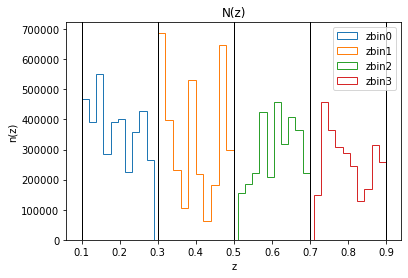

In [45]:
for i in range(4):
    zbin = shear_data[shear_data['zbin']=='zbin'+str(i)]
    plt.hist(zbin['mean_z'],histtype='step',label='zbin'+str(i))
    plt.axvline(zbins_edges[i],linewidth=1, color='black')
plt.axvline(zbins_edges[i+1],linewidth=1, color='black')
plt.legend(loc='best')
plt.ylabel('n(z)')
plt.xlabel('z')
plt.title('N(z)')
plt.show()

## Basic Tests

Checking for a mean shear per bin (note need to change this to include weights).

In [37]:
mean_g1 = shear_data.groupby('zbin').mean()['g1'].values
mean_g2 = shear_data.groupby('zbin').mean()['g2'].values
mean_zs = shear_data.groupby('zbin').mean()['mean_z'].values

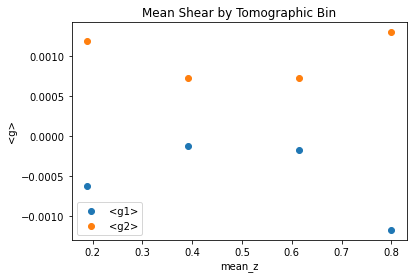

In [38]:
plt.title('Mean Shear by Tomographic Bin')
plt.scatter(mean_zs, mean_g1,label='<g1>')
plt.scatter(mean_zs, mean_g2,label='<g2>')
plt.xlabel('mean_z')
plt.ylabel('<g>')
plt.legend(loc='best')

In [49]:
e1_psf = shear_data['psf_g1']
mmin = -0.03
mmax =0.05
nbin = 20
edges = np.linspace(mmin, mmax, nbin+1)
index = np.digitize(e1_psf, edges)

e1_binned = np.zeros(nbin)
e2_binned = np.zeros(nbin)
e1_psf_binned = np.zeros(nbin)
e2_psf_binned = np.zeros(nbin)
err1 = np.zeros(nbin)
err2 = np.zeros(nbin)


for i in range(nbin):
    w = np.where((index==i+1))[0]
    e1_i = shear_data['g1'][w]
    e2_i = shear_data['g2'][w]
    
    e1_psf_binned[i] = shear_data['psf_g1'][w].mean()
    e1_binned[i] = np.mean(e1_i)
    e2_binned[i] = np.mean(e2_i)
    err1[i] = np.std(e1_i) / np.sqrt(e1_i.size)
    err2[i] = np.std(e2_i) / np.sqrt(e2_i.size)

                 
e2_psf = shear_data['psf_g2']
mmin = -0.03
mmax =0.05
nbin = 20
edges = np.linspace(mmin, mmax, nbin+1)
index = np.digitize(e1_psf, edges)
                 
e1_binned_2 = np.zeros(nbin)
e2_binned_2 = np.zeros(nbin)
err1_2 = np.zeros(nbin)
err2_2 = np.zeros(nbin)
                 
index = np.digitize(e2_psf, edges)

for i in range(nbin):
    w = np.where((index==i+1))[0]
    e1_i = shear_data['g1'][w]
    e2_i = shear_data['g2'][w]

    
    e2_psf_binned[i] = shear_data['psf_g2'][w].mean()
    e1_binned_2[i] = np.mean(e1_i)
    e2_binned_2[i] = np.mean(e2_i)
    err1_2[i] = np.std(e1_i) / np.sqrt(e1_i.size)
    err2_2[i] = np.std(e2_i) / np.sqrt(e2_i.size)

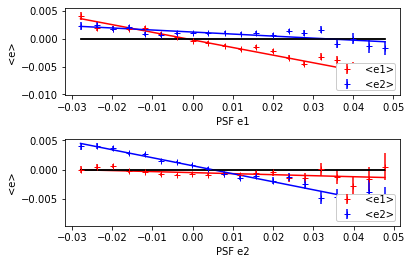

In [52]:
from scipy import stats

mu1 = e1_psf_binned
mu2 = e2_psf_binned
mean11 = e1_binned
mean12 = e2_binned
mean21 = e1_binned_2
mean22 = e2_binned_2
std11 = err1
std12 = err2
std21 = err1_2
std22 = err2_2

slope11, intercept11, r_value11, p_value11, std_err11 = stats.linregress(mu1,mean11)
line11 = slope11*(mu1)+intercept11

slope12, intercept12, r_value12, p_value12, std_err12 = stats.linregress(mu1,mean12)
line12 = slope12*(mu1)+intercept12

slope21, intercept21, r_value21, p_value21, std_err21 = stats.linregress(mu2,mean21)
line21 = slope21*(mu2)+intercept21

slope22, intercept22, r_value22, p_value22, std_err22 = stats.linregress(mu2,mean22)
line22 = slope22*(mu2)+intercept22

plt.subplot(2,1,1)

        
plt.plot(mu1,line11,color='red')
plt.plot(mu1,[0]*len(line11),color='black')

plt.plot(mu1,line12,color='blue')
plt.plot(mu1,[0]*len(line12),color='black')
plt.errorbar(mu1, mean11, std11, label='<e1>', fmt='+',color='red')
plt.errorbar(mu1, mean12, std12, label='<e2>', fmt='+',color='blue')
#plt.yticks(np.arange(-0.0015, 0.002, 0.0005))
#plt.ylim(-0.0015,0.0015)
plt.xlabel("PSF e1")
plt.ylabel("<e>")
plt.legend(loc='lower right',borderpad=.1,framealpha=1.0)


plt.subplot(2,1,2)

plt.plot(mu2,line21,color='red')
plt.plot(mu2,[0]*len(line21),color='black')

plt.plot(mu2,line22,color='blue')
plt.plot(mu2,[0]*len(line22),color='black')
plt.errorbar(mu2, mean21, std21, label='<e1>', fmt='+',color='red')
plt.errorbar(mu2, mean22, std22, label='<e2>', fmt='+',color='blue')
#plt.yticks(np.arange(-0.0015, 0.002, 0.0005))
#plt.ylim(-0.0015,0.0015)
plt.xlabel("PSF e2")
plt.ylabel("<e>")
plt.legend(loc='lower right',borderpad=.1,framealpha=1.0)

plt.subplots_adjust(hspace=0.5)

In [57]:
T = shear_data['psf_T_mean']
mmin = 0.2
mmax = 2.0
nbin = 20
edges = np.linspace(mmin, mmax, nbin+1)
index = np.digitize(T, edges)

e1_binned = np.zeros(nbin)
e2_binned = np.zeros(nbin)
T_binned = np.zeros(nbin)
err1 = np.zeros(nbin)
err2 = np.zeros(nbin)


for i in range(nbin):
    w = np.where((index==i+1))[0]
    e1_i = shear_data['g1'][w]
    e2_i = shear_data['g2'][w]
    
    T_binned[i] = shear_data['psf_T_mean'][w].mean()
    e1_binned[i] = np.mean(e1_i)
    e2_binned[i] = np.mean(e2_i)
    err1[i] = np.std(e1_i) / np.sqrt(e1_i.size)
    err2[i] = np.std(e2_i) / np.sqrt(e2_i.size)

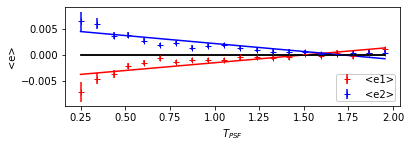

In [59]:
from scipy import stats

mu1 = T_binned
mean11 = e1_binned
mean12 = e2_binned
mean21 = e1_binned_2
mean22 = e2_binned_2
std11 = err1
std12 = err2
std21 = err1_2
std22 = err2_2

slope11, intercept11, r_value11, p_value11, std_err11 = stats.linregress(mu1,mean11)
line11 = slope11*(mu1)+intercept11

slope12, intercept12, r_value12, p_value12, std_err12 = stats.linregress(mu1,mean12)
line12 = slope12*(mu1)+intercept12

plt.subplot(2,1,1)

        
plt.plot(mu1,line11,color='red')
plt.plot(mu1,[0]*len(line11),color='black')

plt.plot(mu1,line12,color='blue')
plt.plot(mu1,[0]*len(line12),color='black')
plt.errorbar(mu1, mean11, std11, label='<e1>', fmt='+',color='red')
plt.errorbar(mu1, mean12, std12, label='<e2>', fmt='+',color='blue')
#plt.yticks(np.arange(-0.0015, 0.002, 0.0005))
#plt.ylim(-0.0015,0.0015)
plt.xlabel(r"$T_{PSF}$")
plt.ylabel("<e>")
plt.legend(loc='lower right',borderpad=.1,framealpha=1.0)